In [8]:
# ============================
# 1. IMPORT LIBRARY
# ============================
import simpy
import random
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple
import statistics

print("✅ Library berhasil diimport")

✅ Library berhasil diimport


In [9]:
# ============================
# 2. KONFIGURASI SIMULASI
# ============================
@dataclass
class Config:
    """Konfigurasi parameter simulasi Piket IT Del"""
    # Parameter dasar
    JUMLAH_MEJA: int = 60
    OMPRENG_PER_MEJA: int = 3
    TOTAL_OMPRENG: int = 60 * 3       # 180 Ompreng
    NUM_PETUGAS: int = 7              # Total 7 mahasiswa piket
    
    # Distribusi waktu (dalam menit)
    LAUK_TIME: tuple = (0.5, 1.0)      # 30-60 detik
    ANGKUT_TIME: tuple = (0.33, 1.0)   # 20-60 detik
    NASI_TIME: tuple = (0.5, 1.0)      # 30-60 detik
    
    # Kapasitas angkut
    BATCH_ANGKUT: tuple = (4, 7)       # Sekali angkut 4-7 ompreng
    
    # Jam mulai
    START_HOUR: int = 7
    START_MINUTE: int = 0
    
    # Seed untuk reproduktibilitas
    RANDOM_SEED: int = 42

print("✅ Konfigurasi simulasi siap")

✅ Konfigurasi simulasi siap


In [10]:
# ============================
# 3. MODEL SIMULASI
# ============================
class PiketKantinDES:
    """Model Discrete Event Simulation untuk Sistem Piket IT Del"""
    
    def __init__(self, config: Config):
        self.config = config
        self.env = simpy.Environment()
        
        # Resource: 7 Mahasiswa sebagai petugas piket
        self.petugas = simpy.Resource(self.env, capacity=config.NUM_PETUGAS)
        
        # Buffer antar tahap
        self.siap_angkut = simpy.Store(self.env)
        self.siap_nasi = simpy.Store(self.env)
        
        # Statistik
        self.statistics = {
            'ompreng_data': [],
            'queue_lengths': [],
            'utilization': []
        }
        
        self.start_time = datetime(2026, 2, 11, config.START_HOUR, config.START_MINUTE)
        self.selesai_count = 0
        
        random.seed(config.RANDOM_SEED)
        np.random.seed(config.RANDOM_SEED)

    def waktu_ke_jam(self, waktu_simulasi: float) -> datetime:
        return self.start_time + timedelta(minutes=waktu_simulasi)

    def proses_isi_lauk(self, ompreng_id: int):
        """Tahap 1: Memasukkan lauk"""
        with self.petugas.request() as req:
            yield req
            durasi = random.uniform(*self.config.LAUK_TIME)
            yield self.env.timeout(durasi)
            yield self.siap_angkut.put({'id': ompreng_id, 'start_lauk': self.env.now - durasi})

    def proses_angkut(self):
        """Tahap 2: Mengangkat ompreng ke meja (Batching)"""
        while self.selesai_count < self.config.TOTAL_OMPRENG:
            batch_size = random.randint(*self.config.BATCH_ANGKUT)
            items = []
            
            # Ambil ompreng yang tersedia untuk diangkut
            for _ in range(batch_size):
                if (self.selesai_count + len(items)) < self.config.TOTAL_OMPRENG:
                    if len(self.siap_angkut.items) > 0:
                        item = yield self.siap_angkut.get()
                        items.append(item)
                    else: break
            
            if items:
                with self.petugas.request() as req:
                    yield req
                    durasi = random.uniform(*self.config.ANGKUT_TIME)
                    yield self.env.timeout(durasi)
                    for item in items:
                        yield self.siap_nasi.put(item)
            else:
                yield self.env.timeout(0.1)

    def proses_isi_nasi(self):
        """Tahap 3: Menambahkan nasi di meja"""
        while self.selesai_count < self.config.TOTAL_OMPRENG:
            data = yield self.siap_nasi.get()
            with self.petugas.request() as req:
                yield req
                durasi = random.uniform(*self.config.NASI_TIME)
                yield self.env.timeout(durasi)
                
                self.selesai_count += 1
                self.statistics['ompreng_data'].append({
                    'id': data['id'],
                    'waktu_mulai': data['start_lauk'],
                    'waktu_selesai': self.env.now,
                    'durasi_total': self.env.now - data['start_lauk'],
                    'jam_selesai': self.waktu_ke_jam(self.env.now)
                })

    def run_simulation(self):
        # Jalankan proses paralel
        for i in range(self.config.TOTAL_OMPRENG):
            self.env.process(self.proses_isi_lauk(i))
        
        self.env.process(self.proses_angkut())
        self.env.process(self.proses_isi_nasi())
        
        self.env.run()
        return self.analyze_results()

    def analyze_results(self):
        df = pd.DataFrame(self.statistics['ompreng_data'])
        results = {
            'total_ompreng': len(df),
            'jam_selesai_terakhir': df['jam_selesai'].max(),
            'durasi_menit': df['waktu_selesai'].max(),
            'avg_proses': df['durasi_total'].mean()
        }
        return results, df

print("✅ Model simulasi Piket siap")

✅ Model simulasi Piket siap


In [11]:
# ============================
# 4. VISUALISASI DAN ANALISIS
# ============================
def run_scenario(num_petugas: int):
    config = Config(NUM_PETUGAS=num_petugas)
    model = PiketKantinDES(config)
    results, df = model.run_simulation()
    
    print(f"\n{'='*60}")
    print(f"SIMULASI PIKET KANTIN IT DEL")
    print(f"{'='*60}")
    print(f"Total Petugas: {num_petugas} Mahasiswa")
    print(f"Jam Mulai    : {model.start_time.strftime('%H:%M')}")
    print(f"Jam Selesai  : {results['jam_selesai_terakhir'].strftime('%H:%M:%S')}")
    print(f"Total Durasi : {results['durasi_menit']:.2f} menit")
    print(f"{'='*60}")
    
    return results, df, model

def visualize_results(df, model, scenario_name=""):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Analisis Piket IT Del {scenario_name}', fontsize=12, fontweight='bold')
    
    # 1. Distribusi Waktu Penyelesaian
    axes[0].hist(df['durasi_total'], bins=15, color='skyblue', edgecolor='black')
    axes[0].set_title('Distribusi Durasi Proses per Ompreng')
    axes[0].set_xlabel('Menit')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Timeline Selesai
    axes[1].plot(df['waktu_selesai'], df.index, color='green')
    axes[1].set_title('Laju Penyelesaian Ompreng')
    axes[1].set_xlabel('Menit Simulasi')
    axes[1].set_ylabel('Jumlah Ompreng')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Fungsi visualisasi dan analisis siap")

✅ Fungsi visualisasi dan analisis siap



SIMULASI PIKET KANTIN IT DEL
Total Petugas: 7 Mahasiswa
Jam Mulai    : 07:00
Jam Selesai  : 09:34:32
Total Durasi : 154.54 menit


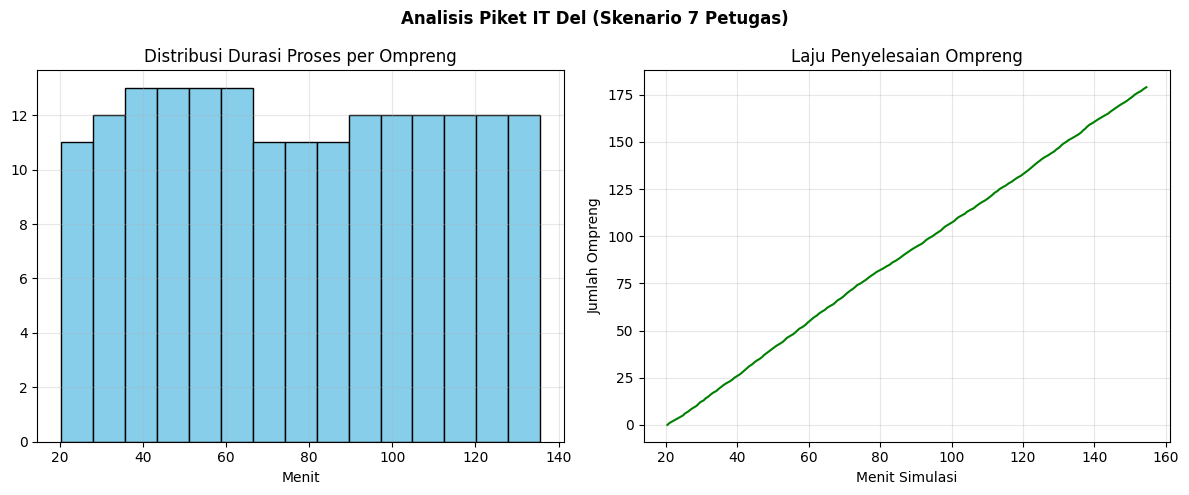

In [12]:
# ============================
# 5. MENJALANKAN SIMULASI
# ============================
results, df, model = run_scenario(num_petugas=7)
visualize_results(df, model, "(Skenario 7 Petugas)")